In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

import re

import treelib

from collections import Counter, defaultdict

import arxiv_tag_lib as at

# ArXiv Tagger

Description of the project goes here...

## 1) Database creation

Here we use the Nature metadata dataset to get the abstracts and keywords of the papers published on the publisher journal.

Since this is a proof of principle project, we focus on a small part of all possible paper, namely those with a keyword contianing *field theory*, as the dataset seems to contain a moderate amount of these articles.

In [2]:
# Set the API key for accessing the database
api_key = os.environ['SPRINGER_API_KEY']

# Create the query and the dataset
query = {'type':'Journal','keyword':"field theory"}
df = at.create_dataframe(query,api_key)

Before we start doing anything on the data, let's just check if some title/abstract/keywords are missing,

In [3]:
# check if titles are missing
is_title_missing = at.missing_entries(df,'title')

# check if abstracts are missing
is_abstract_missing = at.missing_entries(df,'abstract')

There are 0 missing title out of 18071
There are 231 missing abstract out of 18071


And let's do the same for the keywords,

In [4]:
# Some paper have only one keyword that is saved outside a list
df['keywords'] = df['keywords'].apply(lambda item : [item] if type(item) == str else item)

# check if keywords are missing
is_keyword_missing = at.missing_entries(df,'keywords')

There are 0 missing keywords out of 18071


There are abstract that are missing, but no keyword is missing. The missing abstract are not many, and we are probably better off by simply discarding the items without abstract in this case.

In [5]:
df = df[~is_abstract_missing]
df.reset_index(drop=True,inplace=True)

df.to_pickle('./dataset_field_theory.pkl')

## 2) Selecting the labels

Contrary to how APS Journals work, the keywords used on Nature are not taken from a pre-defined set, and instead are assigned by the authors. A drowback of this is that there will be many different keywords and we'd like to select the most common to create the labels for our dataset.

### Cleaning the keywords

Let's start by cleaning up the keywords and getting an idea of the most common ones,

In [2]:
df = pd.read_pickle('./dataset_field_theory.pkl')

df.tail()

,title,abstract,keywords
17835,On the connection between the LSZ and Wightman...,The LSZ asymptotic condition and the Yang-Feld...,"[Neural Network, Statistical Physic, Field The..."
17836,The ground state of the Bose gas,The mathematical formalism describing the Bose...,"[Neural Network, Field Theory, Quantum Field T..."
17837,On the vacuum state in quantum field theory. II,"We want to construct, for every local irreduci...","[Neural Network, Statistical Physic, Field The..."
17838,A theorem concerning the positive metric,It is proved that if the n -point correlation ...,"[Neural Network, Statistical Physic, Field The..."
17839,Geometry of Electromagnetic null field,Electromagnetic tensor field can be divided in...,"[Null Vector, Unify Field Theory, Electromagne..."


The number of different keywords is large, as we can see here,

In [3]:
tags = np.concatenate(df['keywords'].to_numpy())
unique_tags = np.unique(tags)

unique_tags.size

10575

We might be able to slightly reduce the tags if we clean them up
- set in lowercase
- neglect non-alphanumeric words
- stem and remove stopwords

Then we get,

In [4]:
# Select the stemmer and the corpus of stopwords
ps = PorterStemmer()
stp_en = stopwords.words('english')

# clean the tags
df['keywords'] = df['keywords'].apply(lambda item : at.clean_tags(item,ps,stp_en))
df.tail()

,title,abstract,keywords
17835,On the connection between the LSZ and Wightman...,The LSZ asymptotic condition and the Yang-Feld...,"[neural network, statist physic, field theori,..."
17836,The ground state of the Bose gas,The mathematical formalism describing the Bose...,"[neural network, field theori, quantum field t..."
17837,On the vacuum state in quantum field theory. II,"We want to construct, for every local irreduci...","[neural network, statist physic, field theori,..."
17838,A theorem concerning the positive metric,It is proved that if the n -point correlation ...,"[neural network, statist physic, field theori,..."
17839,Geometry of Electromagnetic null field,Electromagnetic tensor field can be divided in...,"[null vector, unifi field theori, electromagne..."


Let's check if we have indeed reduced a bit the number of tags,

In [5]:
tags = np.concatenate(df['keywords'].to_numpy())
unique_tags = np.unique(tags)

unique_tags.size

9230

Let's check the most common tags, to get an idea of what we are dealing with,

In [6]:
tags = np.concatenate(df['keywords'].to_numpy())
tags_frequency = Counter(tags)

tags_frequency.most_common(10)

[('field theori', 9977),
 ('elementari particl', 8830),
 ('quantum field theori', 8803),
 ('particl acceler', 1972),
 ('conform field theori', 1329),
 ('spectroscopi', 1257),
 ('effect field theori', 1119),
 ('state physic', 1077),
 ('ad cft correspond', 1054),
 ('field theori lower dimens', 872)]

It is clear that the first 3 tags (maybe even the 4th one) are a bit too general and we can probably remove them, since a lot of stuff falls broadly under these tags.

### Creating a hierarchy of tags

We now search for the important tags, and will restrict our dataset to the items that contains these tags. We do this by creating a tree of tags.

We can additionally use the hierarchical nature of how tags are assigned in the Nature dataset to only focus on the leafs of the tree and label the corresponding items with their tag.

**NOTE**: We move from a multi-label dataset to a multi-class one. This is not necessarily desirable and maybe in the future we'll try to go for a multi-label problem. For now, we try this approach to see how well we can still classify papers.

In [7]:
# Create the tags tree
tags_tree = treelib.Tree()

# List of tags to avoid (too many items link to them)
avoid_tags=['field theori','elementari particl','quantum field theori','particl acceler']

# Create the root node of the tree and build it
root = tags_tree.create_node('root',data=df.copy())
at.build_tag_tree(tags_tree,root.identifier,avoid_tags,min_size=250)

# Show the tree
tags_tree.show()

root
├── conform field theori
│   └── ad cft correspond
├── dualiti gaug field theori
├── effect field theori
│   └── beyond standard model
├── field theori higher dimens
├── field theori lower dimens
├── gaug theori
├── integr field theori
│   └── ad cft correspond
├── neural network
│   └── complex system
│       └── statist physic
├── quantum mechan
└── spectroscopi
    └── state physic



Let's visualize the size of each class, to see if the problem is balanced or not,

In [8]:
# Get the size of each class and the total size of the dataset we'll be left with
size_tag = defaultdict(int)
total_items = 0

for node in tags_tree.leaves():
    size_tag[node.tag] += node.data.shape[0]
    total_items += node.data.shape[0]
    
tags_number = len(size_tag)

# We can check how may instances of the same tags selected here are present in the full dataset
full_df_size_tag = [tags_frequency[key] for key in size_tag.keys()]

print('We use {} tags, for a grand total of {} items.'.format(tags_number,total_items))

We use 9 tags, for a grand total of 4686 items.


Before we visualize the classes, we'd like to check how many items in the original database contain the same labels. Notice that a single item might contain two or more of the keywords we are using, as they might overlap. 

Due to how we have constructed the tree of tags, we are dividing the items into non-overlapping categories (this might help avoiding having abstract too similar for different topics). However, by doing so we might be losing quite a few items. 

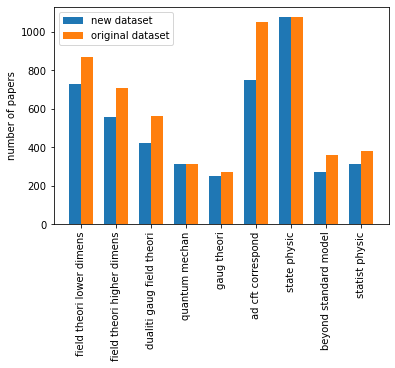

In [9]:
# Visualize the classes size
bar_width = 0.35
positions = np.arange(tags_number)

plt.bar(positions-bar_width/2,size_tag.values(),bar_width,label='new dataset')
plt.bar(positions+bar_width/2,full_df_size_tag,bar_width,label='original dataset')

plt.xticks(range(tags_number),size_tag.keys(),rotation='vertical')

plt.ylabel('number of papers')

plt.legend()
plt.show()

We are losing something, but not so much really. Might need to keep an eye on the *AdS-CFT correspondence* tag.

### Creating the dataset with fixed classes

We can now create the dataset out of the classes we have selected. 

In [10]:
df_tags = pd.DataFrame(columns=['title','abstract','keywords'])

for node in tags_tree.leaves():
    
    df_node = node.data.copy()
    df_node['keywords'] = node.tag
    
    df_tags = df_tags.append(df_node)

df_tags.reset_index(drop=True,inplace=True)
df_tags.to_pickle('./dataset_ft_classified.pkl')

## 3) Understanding the abstracts and titles

Let's see what kind of abstract/titles we are dealing with.

In [2]:
df_tags = pd.read_pickle('./dataset_ft_classified.pkl')
df_tags.sample(n=7)

,title,abstract,keywords
3736,Anomalies of the baric and temperature depende...,The elastic characteristics of ice up to press...,state physic
2428,Lifting of states in 2-dimensional N = 4 super...,We consider states of the D1-D5 CFT where only...,ad cft correspond
3337,Virtual qubits: Multilevels instead of multipa...,The possibility of using multilevel quantum sy...,state physic
1554,Running couplings in quantum theory of gravity...,In this paper we study the coupled system of n...,dualiti gaug field theori
3832,Integrating out new fermions at one loop,We present the fermionic universal one-loop ef...,beyond standard model
101,Self-conjugate QCD,We carry out a systematic study of SU(6) Yang-...,field theori lower dimens
211,Supersymmetric gauged matrix models from dimen...,It was recently proposed that N $$ \mathcal{N}...,field theori lower dimens


### Understanding the abstracts

- how long are the abstract on average?
- how much equations are there?

In [3]:
labels = np.unique(df_tags['keywords'].to_numpy())

Let's see the abstract distribution,

In [4]:
abstract_length = df_tags['abstract'].apply(len).to_numpy()

min_length = min(abstract_length)
max_length = max(abstract_length)

mean_length = np.mean(abstract_length)
median_length = np.median(abstract_length)

print('The length of the abstracts ranges between {} and {} characters'.format(min_length,max_length))
print('The mean length is {}, the median is {}'.format(int(mean_length),int(median_length)))

The length of the abstracts ranges between 54 and 4558 characters
The mean length is 765, the median is 707


In [5]:
# the shortest abstract
df_tags.iloc[np.argmin(abstract_length)]['abstract']

'We prove in a rigorous way the statement of the title.'

Physicists are a rare breed...

In [6]:
# the longest abstract
df_tags.iloc[np.argmax(abstract_length)]['abstract']

"Dopo aver discusso tre vari approcci al formalismo canonico per una linea d'orizzonte in una metrica di background curvo si sviluppa un nuovo formalismo covariante. È basato sull'hamiltoniana che, per τ= s , è uguale alla massa propria e genera traslazioni nel tempo proprio s . Le, relazioni risultanti delle parentesi di Poisson sono equivalenti all'equazione geodesica. Nella teoria quantizzata la quadrivelocità classica è sostituita dall'operatore % MathType!MTEF!2!1!+-% feaafiart1ev1aaatuuDJXwAK1uy0Hwmaerbfv3ySLgzG0uy0Hgip5% wzamXvP5wqonvsaeHbfv3ySLgzaeXatLxBI9gBamXvP5wqSXMqHnxA% Jn0BKvguHDwzZbqehqvATv2CG4uz3bIuV1wyUbqehm0B1jxALjhiov% 2DaebbnrfifHhDYfgasaacH8qrps0lbbf9q8WrFfeuY-Hhbbf9v8qq% aqFr0xc9pk0xbba9q8WqFfea0-yr0RYxir-Jbba9q8aq0-yq-He9q8% qqQ8frFve9Fve9Ff0dmeaaciGacmaadaWabiqaeaqbaqaagaaakeaa% cqaHZoWzdaahaaWcbeqaaiabeY7aTbaaaaa!47C1! $$\\gamma ^\\mu $$ (matrici di Dirac); le equazioni risultanti di Heisenberg sono analoghi quantici dell'equazione di Papapetrou, per una partic

The abstract is written in many languages and has a weird math formatting. It might be good to:

- checking how many abstracts have latex equations.
- checking how many abstracts are written in english

Let's see the distribution of the abstracts,

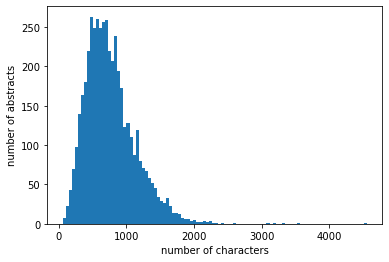

In [7]:
plt.hist(abstract_length,100)
plt.xlabel('number of characters')
plt.ylabel('number of abstracts')
plt.show()

### Let's count the number of equations in the abstract

We do not expect the number of equations to be correlated with the label, but it might be worth a try.

There are between 0 and 14 equations in each abstract.


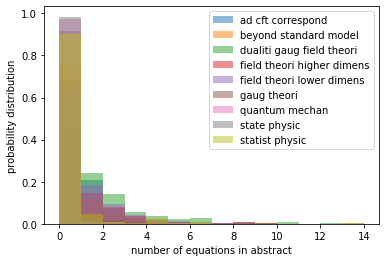

In [8]:
def find_equations(item):
    return len(re.findall('\$+.*?\$+', item))

# create a new column where we store the number of equations in the abstract
df_tags['number of eqs'] = df_tags['abstract'].apply(find_equations)

number_eqs = df_tags['number of eqs'].to_numpy()

max_number_eqs = max(number_eqs)
min_number_eqs = min(number_eqs)

print('There are between {} and {} equations in each abstract.'.format(min_number_eqs,max_number_eqs))

# Plot a histogram to understand if some category of papers have more/less equations than others
bins = np.arange(min_number_eqs,max_number_eqs+1,dtype=np.int)

for tag in labels:
    relevant = df_tags['keywords'] == tag
    number_eqs_tag = df_tags['number of eqs'][relevant].to_numpy()
    plt.hist(number_eqs_tag,bins,density=True,alpha=0.5,label=tag)
    
plt.xlabel('number of equations in abstract')
plt.ylabel('probability distribution')
plt.legend()
plt.show()

Let's also check how often the MathType incident occurs in the abstracts,

In [9]:
contains_mathtype = df_tags['abstract'].apply(lambda item : 'MathType' in item)
df_tags[contains_mathtype]

,title,abstract,keywords,number of eqs
1919,Canonical formalism and quantization of world-...,Dopo aver discusso tre vari approcci al formal...,quantum mechan,5


Only 1 MathType, good! Since anyway we are going to get rid of this one in the next step, let's ignore this for a moment.

### Check language of abstract

We use a package that recognise in which language a text has been written, (it takes a bit of time),

In [10]:
abstract_foreign = df_tags['abstract'].apply(at.is_foreign).to_numpy()
number_foreign = np.sum(abstract_foreign)

print('There are, potentially, {} foreign abstracts.'.format(number_foreign))

There are, potentially, 14 foreign abstracts.


Only a few are not in english, that's great... Let's check which one are not, we expect these to be those with multiple-language abstracts, and we can likely get rid of those.

In [11]:
df_tags['abstract'][abstract_foreign]

1288    Si continua lo studio di uno schema geometrico...
1729    Usando la tecnica delle sequenze spettrali, st...
1730    Мы исследуем секторы фадеева-Попова с зарядом ...
1895    Nondecomposable reducible time representations...
1901    В этой статье мы вычисляем амплитуду перехода ...
1919    Dopo aver discusso tre vari approcci al formal...
1925    A formulation of spinor analysis in space-time...
1927    As a model of gauge theory, we investigate a s...
1930    Si sottolinea che in una teoria che è invarian...
1935    It is shown how a procedure for analytic conti...
1936    Si presenta il formalismo completamente covari...
1944    The construction of a consistent multidimensio...
1945    The construction of a consistent multidimensio...
1952    In questo lavoro si discute la formulazione fu...
Name: abstract, dtype: object

In [12]:
foreign_indices = df_tags[abstract_foreign].index
df_tags.drop(foreign_indices,inplace=True)

### Understanding the titles

Pretty much is the same as before, let's see the lenght of the titles, 

In [13]:
title_length = df_tags['title'].apply(len).to_numpy()

min_length_title = min(title_length)
max_length_title = max(title_length)

mean_length_title = np.mean(title_length)
median_length_title = np.median(title_length)

print('The length of the abstracts ranges between {} and {} characters'.format(min_length_title,max_length_title))
print('The mean length is {}, the median is {}'.format(int(mean_length_title),int(median_length_title)))

The length of the abstracts ranges between 7 and 1249 characters
The mean length is 77, the median is 64


In [14]:
# the shortest title
df_tags.iloc[np.argmin(title_length)]['title']

'AGT/ℤ_2'

In [15]:
# the longest title
df_tags.iloc[np.argmax(title_length)]['title']

'Self-dual continuous series of representations for \n                \n                  \n                \n                \n                  \n                    \n                      U\n                      q\n                    \n                    \n                      \n                        s\n                        l\n                        \n                          2\n                        \n                      \n                    \n                  \n                \n                $$ {\\mathcal{U}}_q\\left(sl(2)\\right) $$\n               and \n                \n                  \n                \n                \n                  \n                    \n                      U\n                      q\n                    \n                    \n                      \n                        o\n                        s\n                        p\n                        \n                          \n                            1\n            

Let's check the distribution of the titles,

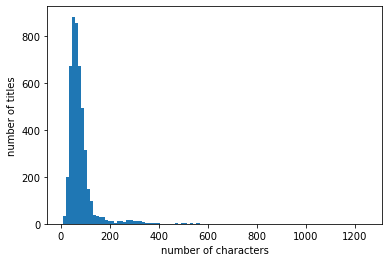

In [16]:
plt.hist(title_length,100)
plt.xlabel('number of characters')
plt.ylabel('number of titles')
plt.show()

I do not think there is much more to do here, since everything seems to be more or less fine and we just need to clean up the tiles a bit.

## 4) Cleaning title and abstracts

We can now use standard NLP techniques to clean up the abstract and title field, that is,

    1) remove math equations
    2) tokenize
    3) remove punctuation
    4) set in lowercase
    5) remove symbols
    6) remove stopwords
    7) perform stemming or lemmatization

### Cleaning the abstracts

Let's clean the abstracts first,

In [17]:
# lemmatizer for processing the abstracts
wn_lemmatizer = WordNetLemmatizer()

# let's clean the abstracts and save the cleand version in a new columns
df_tags['clean abs'] = df_tags['abstract'].apply(at.clean_text_lemmatize,args=(wn_lemmatizer,))

Let's see how many features we have created with the cleaning,

In [18]:
words = np.concatenate(df_tags['clean abs'].to_numpy())
unique_words = np.unique(words)

unique_words.size

11000

And the most common words,

In [19]:
word_frequency = Counter(words)
word_frequency.most_common()

[('theory', 6155),
 ('field', 3578),
 ('n', 2887),
 ('model', 2413),
 ('gauge', 2039),
 ('function', 1913),
 ('operator', 1821),
 ('2', 1694),
 ('quantum', 1689),
 ('result', 1688),
 ('1', 1608),
 ('state', 1604),
 ('two', 1421),
 ('also', 1414),
 ('show', 1319),
 ('dimension', 1284),
 ('study', 1261),
 ('space', 1249),
 ('symmetry', 1208),
 ('equation', 1184),
 ('case', 1134),
 ('limit', 1126),
 ('one', 1110),
 ('conformal', 1069),
 ('term', 1021),
 ('coupling', 1014),
 ('system', 957),
 ('using', 956),
 ('order', 937),
 ('find', 936),
 ('energy', 933),
 ('large', 869),
 ('new', 849),
 ('structure', 845),
 ('solution', 816),
 ('point', 807),
 ('parameter', 779),
 ('shown', 776),
 ('scalar', 771),
 ('u', 749),
 ('phase', 748),
 ('boundary', 740),
 ('obtained', 738),
 ('amplitude', 721),
 ('method', 715),
 ('particle', 706),
 ('condition', 702),
 ('group', 702),
 ('duality', 698),
 ('general', 696),
 ('spin', 687),
 ('mass', 686),
 ('4', 684),
 ('dual', 665),
 ('effective', 660),
 ('for

Seems good. Let's more on to the titles now

### Cleaning the titles

Same drill as before, let's clean by removing equations, symbols, and lemmatizing

In [20]:
# let's clean the title and save the cleand version in a new columns
df_tags['clean title'] = df_tags['title'].apply(at.clean_text_lemmatize,args=(wn_lemmatizer,))

Let's see what are the unique words in the titles,

In [21]:
words_title = np.concatenate(df_tags['clean title'].to_numpy())
unique_words_title = np.unique(words_title)

unique_words_title.size

3515

In [22]:
word_frequency_title = Counter(words_title)
word_frequency_title.most_common()

[('theory', 1067),
 ('field', 656),
 ('quantum', 554),
 ('model', 362),
 ('gauge', 328),
 ('n', 244),
 ('conformal', 207),
 ('dimension', 189),
 ('duality', 169),
 ('function', 164),
 ('state', 162),
 ('mechanic', 160),
 ('symmetry', 158),
 ('1', 142),
 ('2', 139),
 ('operator', 139),
 ('system', 133),
 ('structure', 133),
 ('effect', 129),
 ('scattering', 127),
 ('spin', 120),
 ('space', 120),
 ('magnetic', 116),
 ('entanglement', 114),
 ('supersymmetric', 112),
 ('entropy', 111),
 ('equation', 110),
 ('string', 108),
 ('effective', 107),
 ('lattice', 103),
 ('holographic', 103),
 ('phase', 102),
 ('particle', 99),
 ('amplitude', 98),
 ('interaction', 97),
 ('matter', 96),
 ('loop', 96),
 ('gravity', 93),
 ('3d', 93),
 ('classical', 86),
 ('ad', 85),
 ('higher', 84),
 ('dynamic', 80),
 ('higgs', 79),
 ('spectrum', 79),
 ('wave', 79),
 ('two', 78),
 ('limit', 77),
 ('electron', 76),
 ('large', 75),
 ('transition', 74),
 ('coupling', 74),
 ('new', 73),
 ('surface', 71),
 ('4', 70),
 ('e

Pretty similar to what we had in the abstract, which makes sense.

### Check if cleaned abstracts or titles are empty

Just to be sure, let's check if the cleaned versions of title/abstract are all non-empty,

In [23]:
# check the titles
title_empty = df_tags['clean title'].apply(lambda item : len(item) == 0).to_numpy()
number_of_empty_titles = np.sum(title_empty)

# check the abstracts
abstract_empty = df_tags['clean abs'].apply(lambda item : len(item) == 0).to_numpy()
number_of_empty_abs = np.sum(abstract_empty)

print('There are {} missing titles and {} missing abstracts'.format(number_of_empty_titles,number_of_empty_abs))

There are 8 missing titles and 0 missing abstracts


In [24]:
# Need to continue here, we need to move toward vectorizing the words

In [26]:
df_tags.to_pickle('./dataset_ft_cleaned.pkl')